In [1]:
import kagglehub

path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\tan04\.cache\kagglehub\datasets\awsaf49\coco-2017-dataset\versions\2


In [2]:
base_path = path
training_image_path = "\\coco2017\\train2017"
training_label_path = "\\coco2017\\annotations\\instances_train2017.json"


In [3]:
import json

with open(base_path + training_label_path, 'r') as file:
    data = json.load(file)


In [4]:
cat_id2name = {cat["id"]:cat["name"] for cat in data["categories"]}
cat_name2id = {cat["name"]:cat["id"] for cat in data["categories"]}
image_id2file = { image['id']: image['file_name'] for image in data['images']}

In [5]:
images_label = dict()
for obj in data['annotations']:
    image_id = obj["image_id"]
    if image_id in images_label:
        images_label[image_id]["segmentation"].append(obj["segmentation"])
        images_label[image_id]["area"].append(obj["area"])
        images_label[image_id]["iscrowd"].append(obj["iscrowd"])
        images_label[image_id]["bbox"].append(obj["bbox"])
        images_label[image_id]["category_id"].append(obj["category_id"])
    else:
        label = {
            "segmentation": [obj["segmentation"]],
            "area": [obj["area"]],
            "iscrowd": [obj["iscrowd"]],
            "bbox": [obj["bbox"]],
            "category_id": [obj["category_id"]]
        }
        images_label[image_id] = label
        
    
    


In [21]:
import cv2
COLOUR = (0,0,255)

def show_image(image_id):
    image = cv2.imread(base_path + training_image_path + f'\\{image_id2file[image_id]}')
    
    for bbox in images_label[image_id]["bbox"]:
    
        top_left = (int(bbox[0]), int(bbox[1]))
    
        box_width = int(bbox[2])
        box_height = int(bbox[3])
    
    
        bottom_right = (top_left[0] + box_width, top_left[1] + box_height)
    
        cv2.rectangle(image, top_left, bottom_right, COLOUR, 1)
    
    
    cv2.imshow(f"{image_id}", image)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [6]:
import random

for x in range(10):
    
    image_id = random.choice(list(images_label.keys()))
    show_image(image_id)


In [7]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  



C:\Users\tan04\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\tan04\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\tan04/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:07<00:00, 22.1MB/s] 


In [16]:
image_id = random.choice(list(images_label.keys()))
image = cv2.imread(base_path + training_image_path + f'\\{image_id2file[image_id]}')

image_tensor = torch.from_numpy(image).permute(2, 0, 1)

image_tensor = image_tensor/255

In [17]:
with torch.no_grad():
    predictions = model([image_tensor])

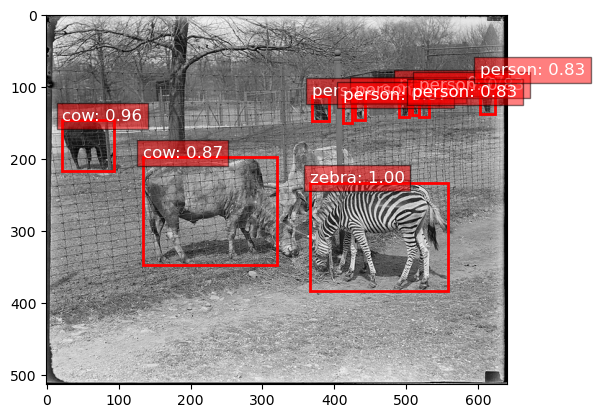

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get predictions for boxes with a confidence threshold
threshold = 0.8
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']
labels = predictions[0]['labels']

filtered_boxes = boxes[scores > threshold]
filtered_scores = scores[scores > threshold]
filtered_labels = labels[scores > threshold]

fig, ax = plt.subplots(1)
ax.imshow(image)

for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(xmin, ymin, f'{cat_id2name[label.item()]}: {score:.2f}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

plt.show()


In [22]:
show_image(image_id)